In [44]:
import praw
import pandas as pd
from urllib.parse import urlparse
from datetime import datetime
import os
from dotenv import load_dotenv

load_dotenv()

reddit = praw.Reddit(
    client_id= os.getenv('client_id'),
    client_secret= os.getenv('client_secret'),
    user_agent= os.getenv('user_agent')
)

def get_subreddit(name):
    subreddit = reddit.subreddit(name)
    #gets the info of the subreddit
    subreddit_info = {
        'name': name,
        'subscribers': subreddit.subscribers,
        'created_utc': datetime.utcfromtimestamp(subreddit.created_utc),
        'display_name': subreddit.display_name,
        'title': subreddit.title,
        'public_description': subreddit.public_description,
    }
    
    return subreddit_info

def get_post_data(name, limit=100):
    subreddit = reddit.subreddit(name)
    posts = []
    
    # Get posts
    for post in subreddit.hot(limit=limit):
        post_data = {
            'title': post.title,
            'score': post.score, 
            'Number of Comments': post.num_comments,
            'selftext': post.selftext,
            'Comments': []
        }
        # Gets comments under the post
        post.comments.replace_more(limit=10)
        for comment in post.comments.list():
            comment_data = {
                'body': comment.body,
                'score': comment.score
            }
            post_data['Comments'].append(comment_data)
                
        posts.append(post_data) 
    
    return posts

In [45]:
python_subreddit = get_post_data('python')
nba_subreddit = get_post_data('nba')
soccer_subreddit = get_post_data('soccer')

### Clean up the text so we can train it

In [46]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def grab_comments(subreddit_data):
    all_comments = []
    for post in subreddit_data:
        for comment in post['Comments']:
            all_comments.append(comment['body'])
    return all_comments

cleaned_nba_comments = [preprocess_text(comment) for comment in grab_comments(nba_subreddit)]
cleaned_python_comments = [preprocess_text(comment) for comment in grab_comments(python_subreddit)]
cleaned_soccer_comments = [preprocess_text(comment) for comment in grab_comments(soccer_subreddit)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Extracts the top topics from each post

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def extract_topics(subreddit_data, n_topics=5):
    # Combine post titles and text
    texts = []
    for post in subreddit_data:
        combined_text = post['title'] + ' ' + post['selftext']
        texts.append(preprocess_text(combined_text))
    
    # Add comments
    for post in subreddit_data:
        for comment in post['Comments']:
            texts.append(preprocess_text(comment['body']))
    
    # Create document-term matrix
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
    dtm = vectorizer.fit_transform(texts)
    
    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract top words for each topic
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10 - 1:-1]
        top_words = {feature_names[i]: topic[i] for i in top_words_idx}
        topics.append(top_words)

    
    return topics

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(topics):
    for idx, topic in enumerate(topics):
        wc = WordCloud(width=800, height=400, background_color='white')
        wc.generate_from_frequencies(topic)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic #{idx+1}")
        plt.tight_layout()
        plt.show()

### Calculates the polarity score of each post and comments

In [48]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


def analyze_sentiment(subreddit_data):
    sia = SentimentIntensityAnalyzer()
    
    # Analyze post sentiments
    post_sentiments = []
    for post in subreddit_data:
        combined_text = post['title'] + ' ' + post['selftext']
        sentiment = sia.polarity_scores(combined_text)
        post_sentiments.append(sentiment)
    
    # Analyze comment sentiments
    comment_sentiments = []
    for post in subreddit_data:
        for comment in post['Comments']:
            sentiment = sia.polarity_scores(comment['body'])
            comment_sentiments.append(sentiment)
    
    # Calculate average sentiments for posts
    if post_sentiments:
        total_compound = 0
        total_pos = 0
        total_neg = 0
        total_neutral = 0

        for i in post_sentiments:
            total_compound += i['compound']
            total_pos += i['pos']
            total_neg += i['neg']
            total_neutral += i['neu']

        count = len(post_sentiments)
        avg_post_sentiment = {
            'compound': total_compound / count,
            'positive': total_pos / count,
            'negative': total_neg / count,
            'neutral': total_neutral / count
        }
    
    # Calculate average sentiments for comments
    if comment_sentiments:
        total_compound = 0
        total_pos = 0
        total_neg = 0
        total_neutral = 0

        for i in comment_sentiments:
            total_compound += i['compound']
            total_pos += i['pos']
            total_neg += i['neg']
            total_neutral += i['neu']

        count = len(comment_sentiments)
        avg_comment_sentiment = {
            'compound': total_compound / count,
            'positive': total_pos / count,
            'negative': total_neg / count,
            'neutral': total_neutral / count
        }
        
    return {
        'post_sentiment': avg_post_sentiment,
        'comment_sentiment': avg_comment_sentiment
    }


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_word_frequency(subreddit_data, top_n=20):
    all_text = ''.join(subreddit_data)
    preprocessed_text = preprocess_text(all_text)
    
    words = preprocessed_text.split()
    word_counts = Counter(words)

    top_words = word_counts.most_common(top_n)
    
    return top_words

def plot_word_frequency(top_words, subreddit_name):
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top {len(words)} Words in r/{subreddit_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    
    return plt

### Time to analyze the data

Simple statistical analysis from each community

In [50]:
python_stats = analyzeCommunity(python_subreddit, 'python')
nba_stats = analyzeCommunity(nba_subreddit, 'nba')
soccer_stats = analyzeCommunity(soccer_subreddit, 'soccer')
print(python_stats)
print(nba_stats)
print(soccer_stats)


{'subreddit': 'python', 'total_posts': 100, 'avg_post_score': 36.49, 'total_comments': 1404, 'avg_comments_per_post': 14.04, 'total_comments_collected': 1398, 'avg_comment_score': 5.670243204577969}
{'subreddit': 'nba', 'total_posts': 100, 'avg_post_score': 2187.71, 'total_comments': 28331, 'avg_comments_per_post': 283.31, 'total_comments_collected': 21338, 'avg_comment_score': 37.260193082763145}
{'subreddit': 'soccer', 'total_posts': 100, 'avg_post_score': 1599.2, 'total_comments': 13416, 'avg_comments_per_post': 134.16, 'total_comments_collected': 11871, 'avg_comment_score': 45.83143795804903}


Analyze word freq for each subreddit

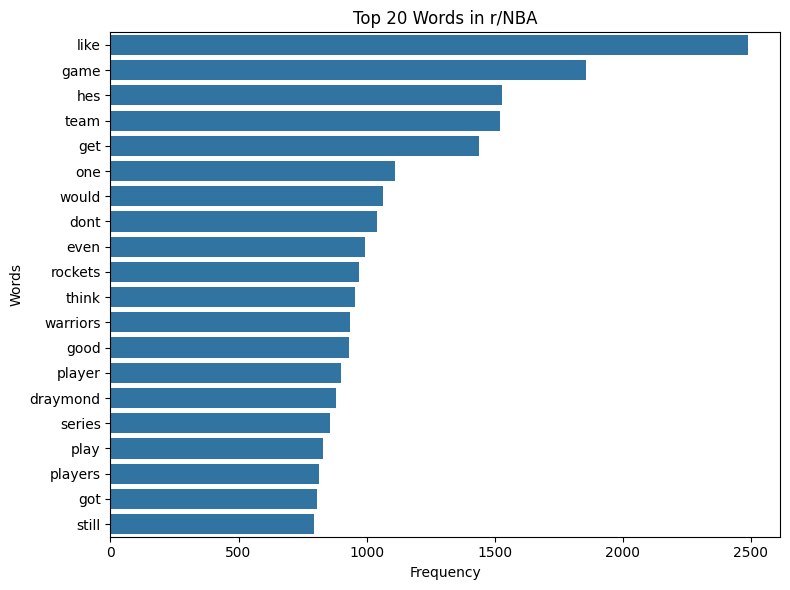

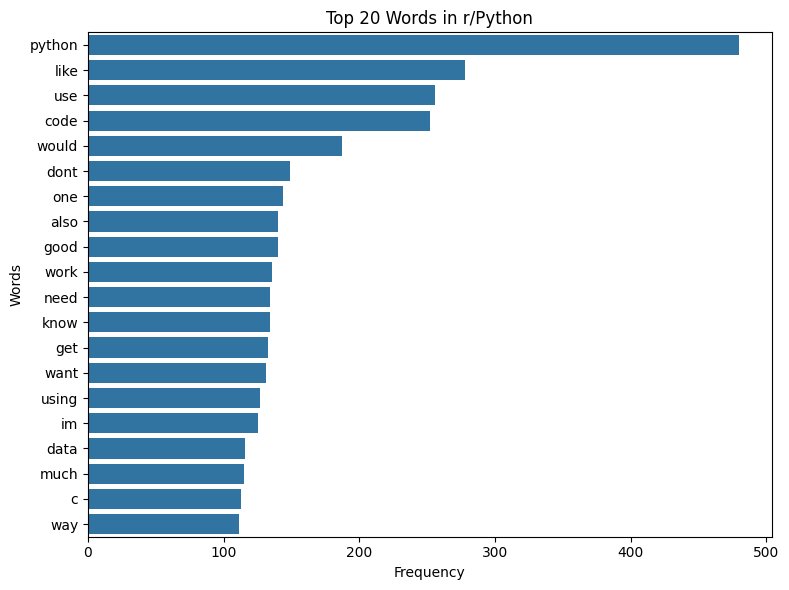

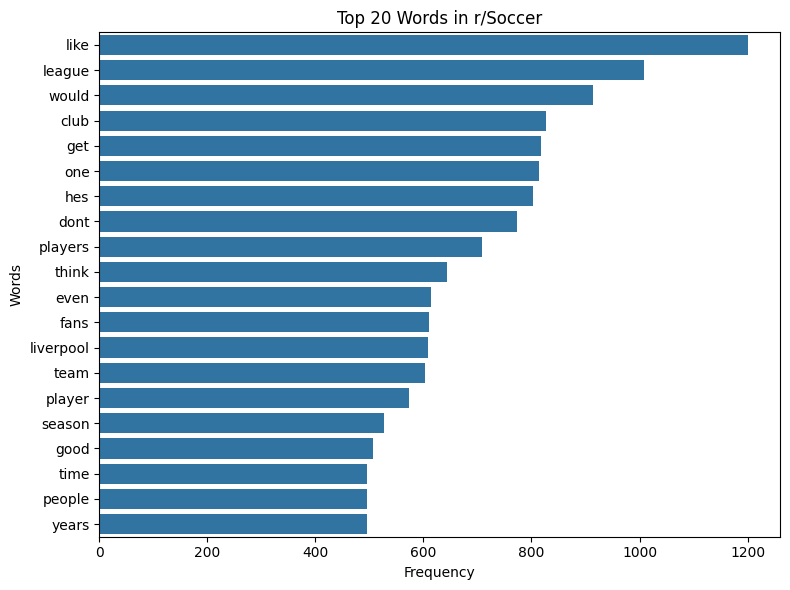

In [51]:
nba_top_words = analyze_word_frequency(cleaned_nba_comments)
nba_plot = plot_word_frequency(nba_top_words, "NBA")
plt.show()

python_top_words = analyze_word_frequency(cleaned_python_comments)
python_plot = plot_word_frequency(python_top_words, "Python")
plt.show()

soccer_top_words = analyze_word_frequency(cleaned_soccer_comments)
soccer_plot = plot_word_frequency(soccer_top_words, "Soccer")
plt.show()




Analyzed the polarity of each comment and post to see if its postive, negative or neutral

In [52]:
soccer_sentiment_results = analyze_sentiment(soccer_subreddit)
soccer_sentiment_results



{'post_sentiment': {'compound': 0.11203300000000002,
  'positive': 0.10997000000000001,
  'negative': 0.04740999999999998,
  'neutral': 0.8426499999999999},
 'comment_sentiment': {'compound': 0.15925254822676946,
  'positive': 0.147229214051049,
  'negative': 0.08229946929492056,
  'neutral': 0.768706932861596}}

In [53]:
python_sentiment_results = analyze_sentiment(python_subreddit)
python_sentiment_results

{'post_sentiment': {'compound': 0.694324,
  'positive': 0.12232000000000001,
  'negative': 0.025399999999999995,
  'neutral': 0.8521999999999997},
 'comment_sentiment': {'compound': 0.29123276108726764,
  'positive': 0.1387761087267524,
  'negative': 0.04544849785407725,
  'neutral': 0.8157739628040057}}

In [54]:
nba_sentiment_results = analyze_sentiment(nba_subreddit)
nba_sentiment_results

{'post_sentiment': {'compound': 0.18805900000000006,
  'positive': 0.08457,
  'negative': 0.05862000000000001,
  'neutral': 0.8568400000000003},
 'comment_sentiment': {'compound': 0.09130029056143939,
  'positive': 0.1352428999906278,
  'negative': 0.09912601930827594,
  'neutral': 0.765115896522635}}

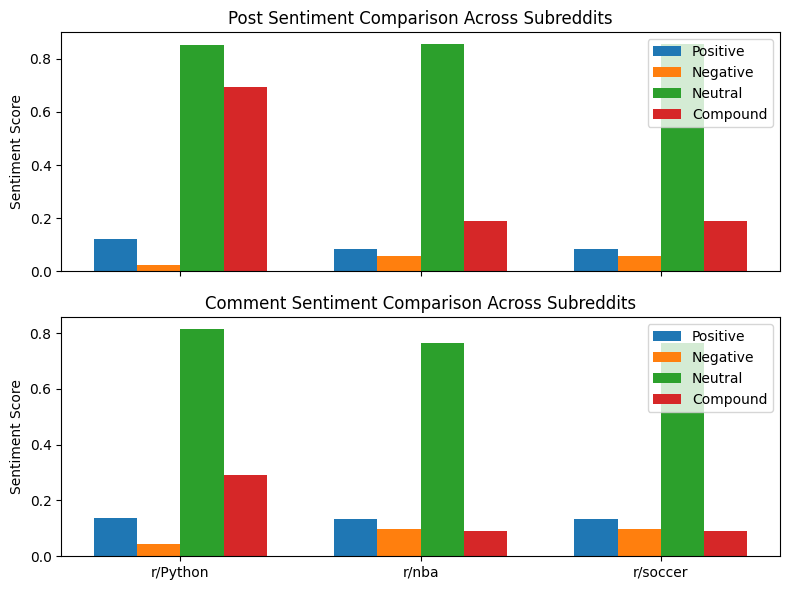

In [60]:
import matplotlib.pyplot as plt
import numpy as np

sentiments = {
    'r/Python': {
        'post': {'positive': 0.12232, 'negative': 0.0254, 'neutral': 0.8522, 'compound': 0.6943},
        'comment': {'positive': 0.1388, 'negative': 0.0454, 'neutral': 0.8158, 'compound': 0.2912}
    },
    'r/nba': {
        'post': {'positive': 0.08457, 'negative': 0.05862, 'neutral': 0.85684, 'compound': 0.1881},
        'comment': {'positive': 0.1352, 'negative': 0.0991, 'neutral': 0.7651, 'compound': 0.0913}
    },
    'r/soccer': {
        'post': {'positive': 0.08457, 'negative': 0.05862, 'neutral': 0.85684, 'compound': 0.1881},
        'comment': {'positive': 0.1352, 'negative': 0.0991, 'neutral': 0.7651, 'compound': 0.0913}
    }
}

categories = ['positive', 'negative', 'neutral', 'compound']
subreddits = list(sentiments.keys())
x = np.arange(len(subreddits))  # label locations
width = 0.18  # width of bars

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot post sentiment
for i, cat in enumerate(categories):
    values = [sentiments[sub]['post'][cat] for sub in subreddits]
    ax[0].bar(x + i*width, values, width, label=cat.capitalize())

ax[0].set_title('Post Sentiment Comparison Across Subreddits')
ax[0].set_ylabel('Sentiment Score')
ax[0].legend()
ax[0].set_xticks(x + width * 1.5)
ax[0].set_xticklabels(subreddits)

# Plot comment sentiment
for i, cat in enumerate(categories):
    values = [sentiments[sub]['comment'][cat] for sub in subreddits]
    ax[1].bar(x + i*width, values, width, label=cat.capitalize())

ax[1].set_title('Comment Sentiment Comparison Across Subreddits')
ax[1].set_ylabel('Sentiment Score')
ax[1].set_xticks(x + width * 1.5)
ax[1].set_xticklabels(subreddits)
ax[1].legend()

plt.tight_layout()
plt.show()


Look at the top topics 

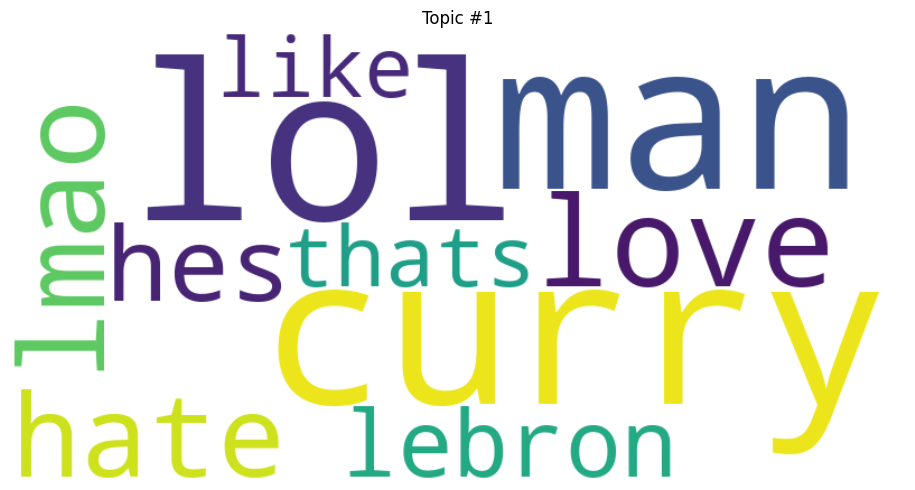

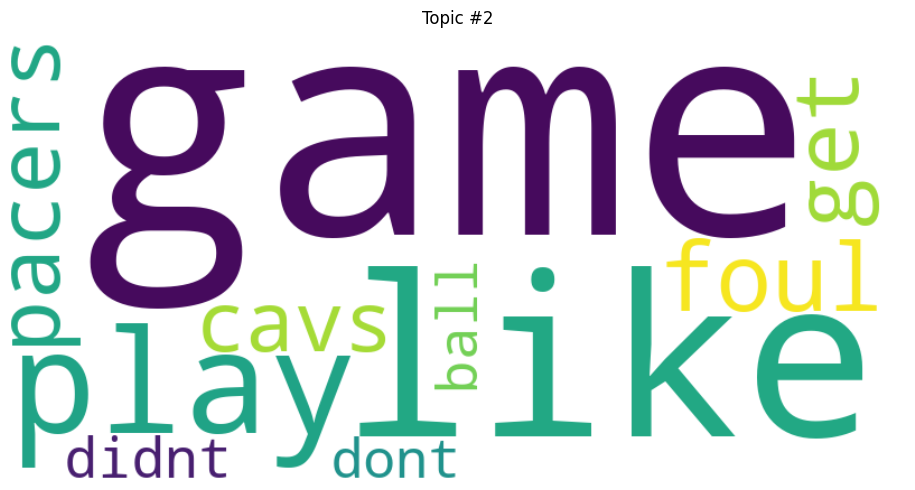

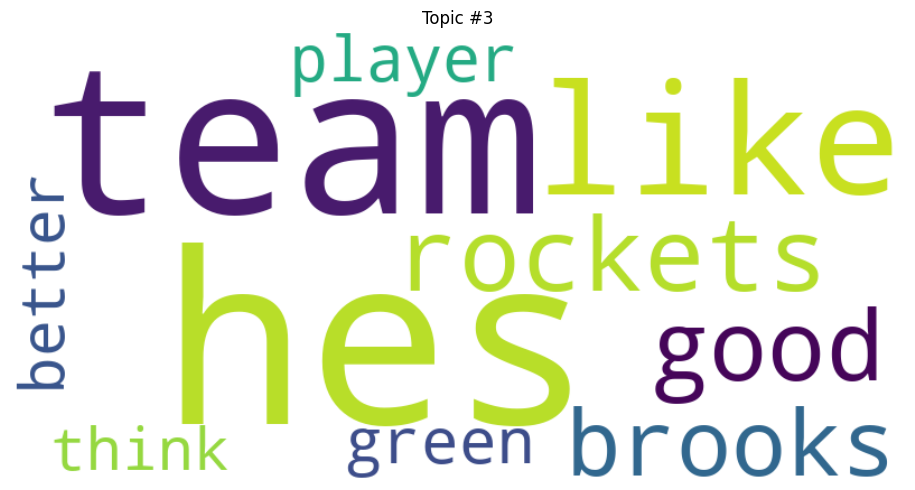

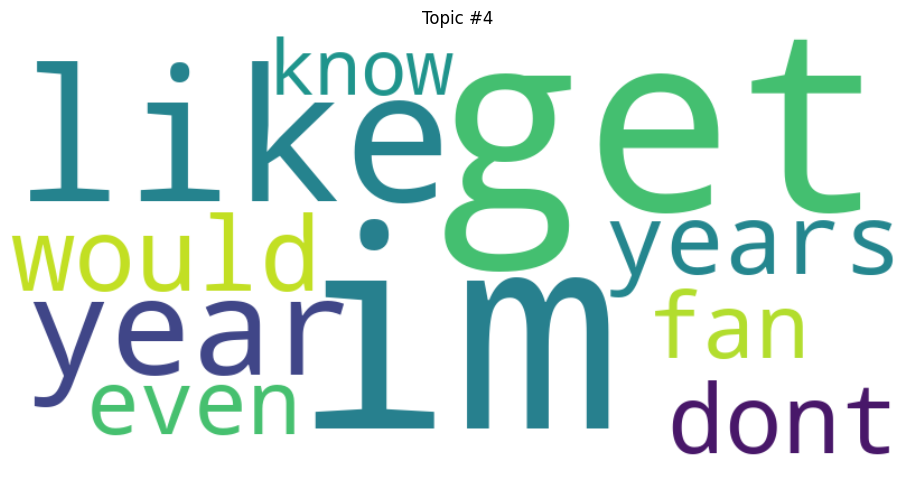

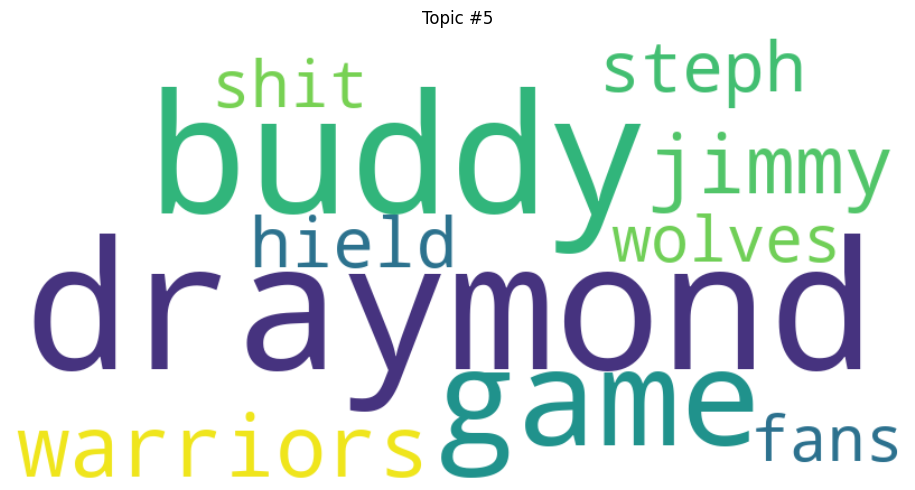

In [72]:
nba_topics = extract_topics(nba_subreddit)
plot_wordclouds(nba_topics)

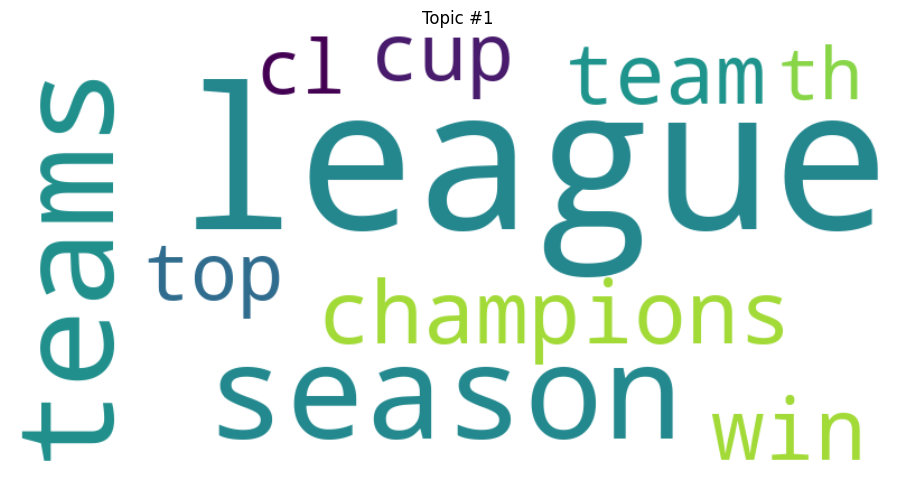

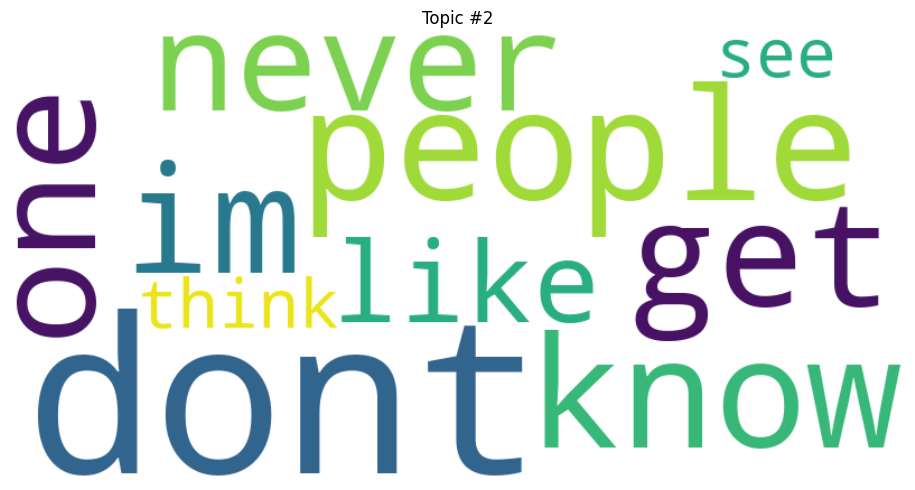

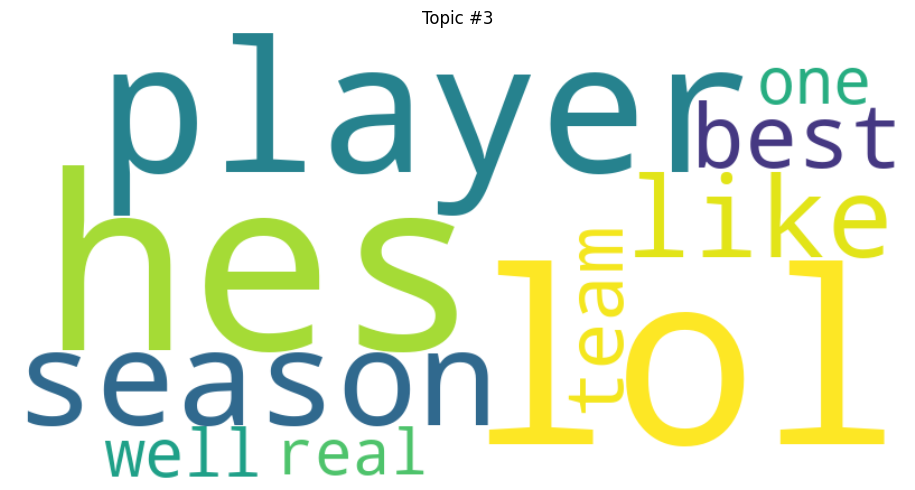

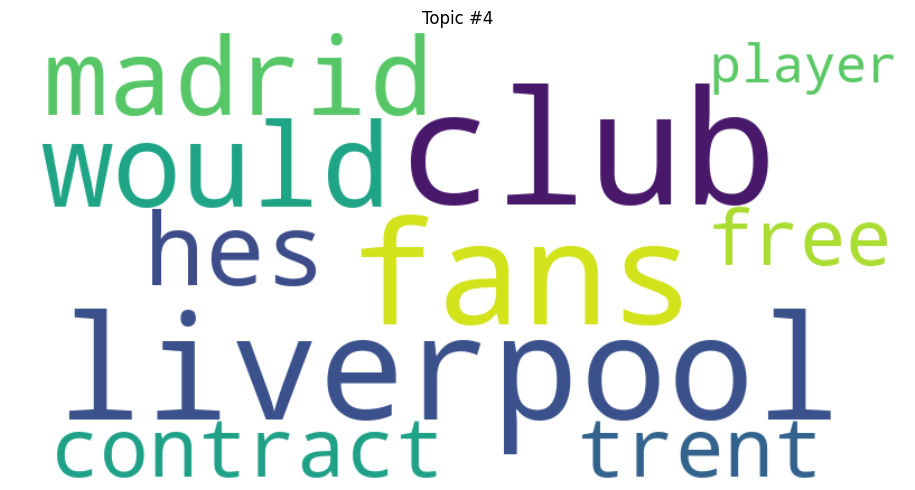

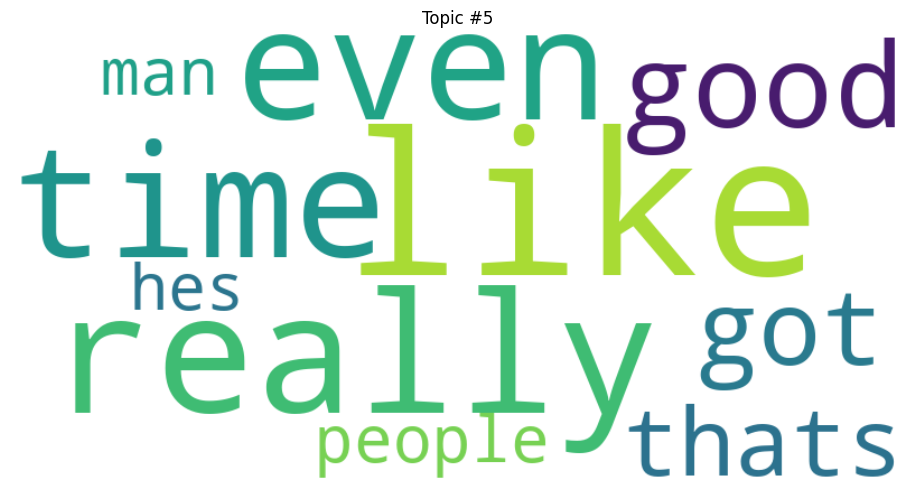

In [71]:
soccer_topics = extract_topics(soccer_subreddit)
plot_wordclouds(soccer_topics)


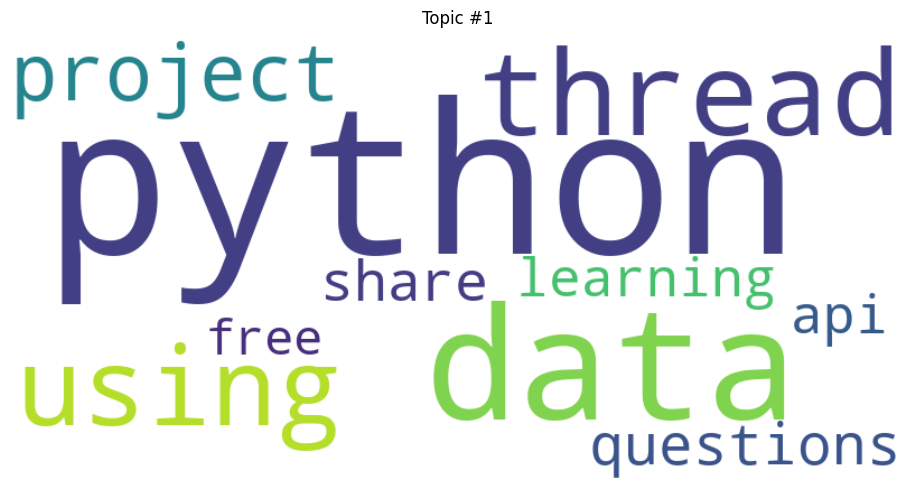

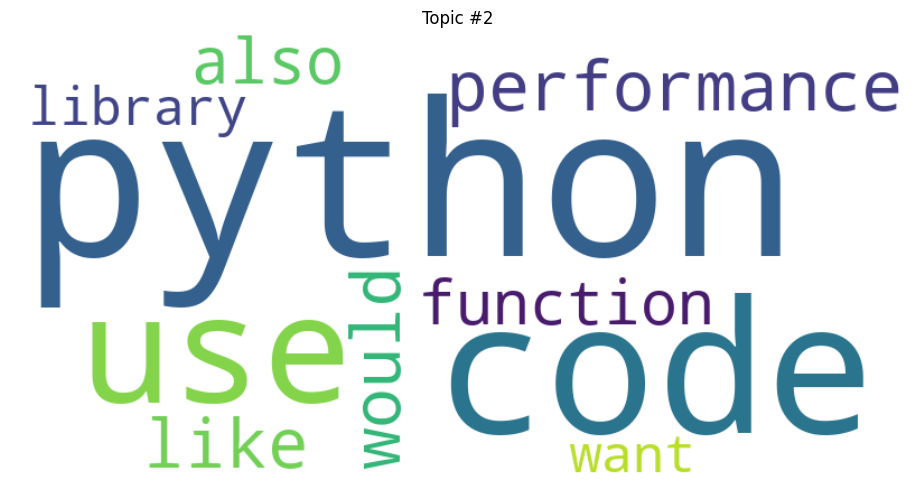

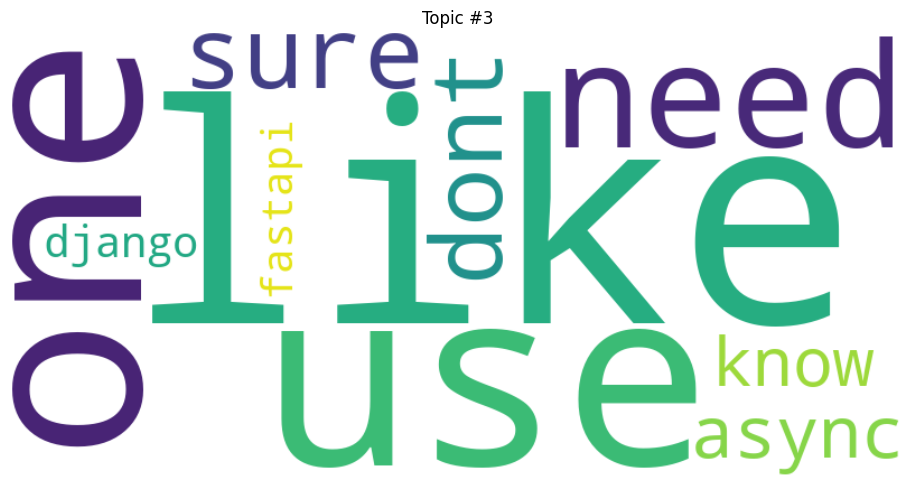

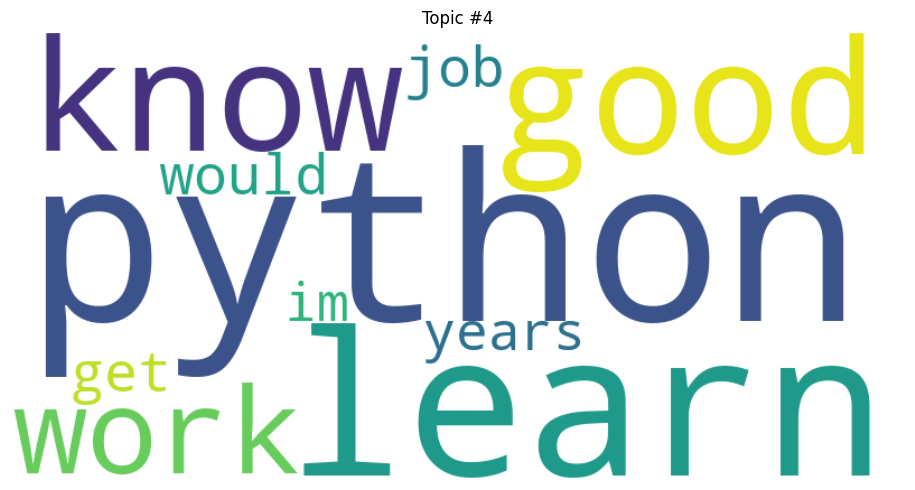

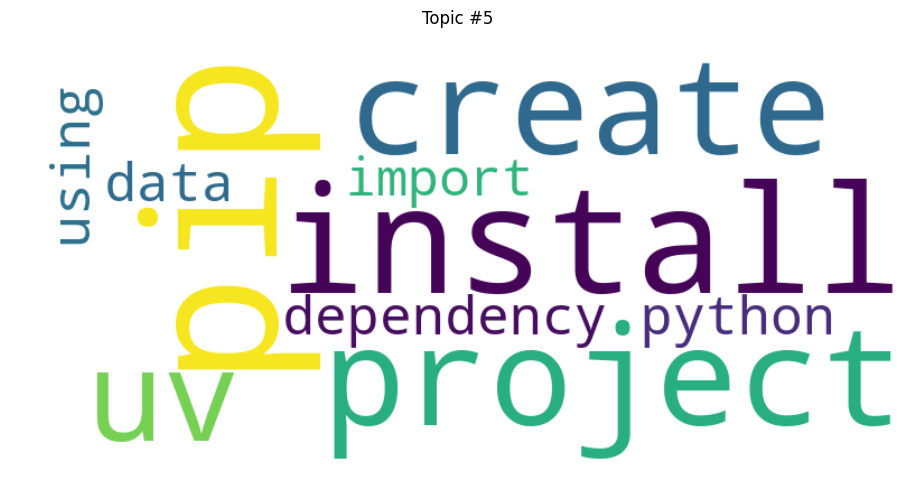

In [70]:
python_topics = extract_topics(python_subreddit)

plot_wordclouds(python_topics)


